In [1]:
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR_ALN as HALOVI
from complementary_models import HALOMASKVAE_ALN as HALOVAE
import scanpy as sc
import scvi
from matplotlib import pyplot as plt

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)    

gate decoder initialization n_input 20, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
model = model.load("model_hair_align_causal01_20",adata_mvi)

INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
gate decoder initialization n_input 20, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [8]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)

In [8]:
## no need to show
# adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)
# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype', 'latent_time'], title="RNA")

In [6]:
import pandas as pd
adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8)
adata_mvi.obs["latent_time_8"] = adata_mvi.obs["latent_time_8"].apply(lambda x: x.right)
adata_mvi.obs["latent_time_8"]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0_paired       0.375
1_paired       0.500
2_paired       0.250
3_paired       0.375
4_paired       0.250
               ...  
6431_paired    0.375
6432_paired    0.375
6433_paired    0.375
6434_paired    0.500
6435_paired    0.500
Name: latent_time_8, Length: 6436, dtype: category
Categories (8, float64): [0.125 < 0.250 < 0.375 < 0.500 < 0.625 < 0.750 < 0.875 < 1.000]

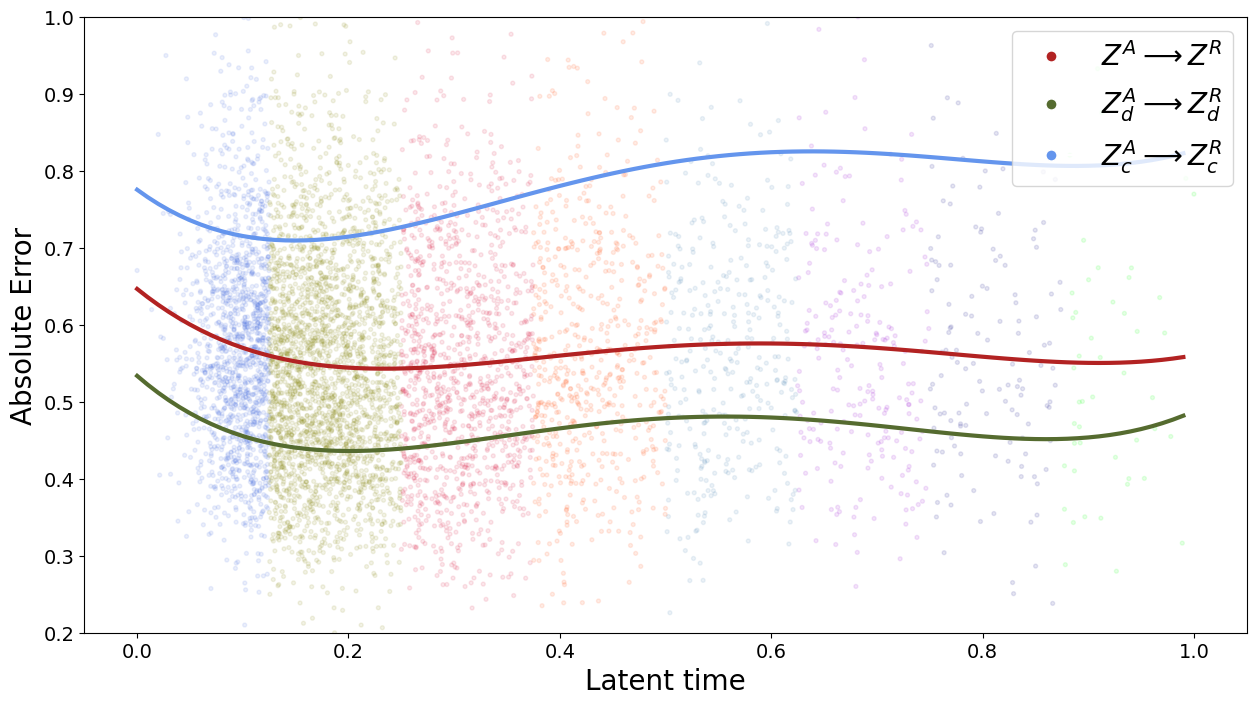

In [7]:
## RNA and atac representation analysis
from numpy.linalg import inv 
from matplotlib.lines import Line2D


colors = ['crimson', 'orangered', 'olive', 'royalblue', 'steelblue', "darkviolet", "navy", "lime"]
# colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', 
#           '#FF7F00', '#FFFF33', '#A65628', '#F781BF']
cell_type = [i for i in adata_mvi.obs["latent_time_8"].unique()]
# cmap = plt.cm.Pastel1  # define the colormap
# colors = [cmap(i) for i in range(8)]
colors = dict(zip(cell_type, colors))


X = latent_acc
Y = latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)
Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_1 = np.mean(np.abs(Y_Residual),axis=1)



z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_1, 4)
p = np.poly1d(z)



X = latent_atac_dep
Y = latent_expr_dep

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_2 = np.mean(np.abs(Y_Residual),axis=1)

z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_2, 4)
p_1 = np.poly1d(z)



X = latent_atac_indep
Y = latent_expr_indep

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)

z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_3, 4)
p_2 = np.poly1d(z)



%matplotlib inline

fig, ax = plt.subplots(figsize=(15,8))

plt.scatter(adata_mvi.obs['latent_time'], Y_Residual_1, color=adata_mvi.obs['latent_time_8'].map(colors),s=8.0, alpha = 0.1)


Times = np.arange(0.0, 1.0, 0.01)
# Times = np.arange(0.0, 8.0, 0.01)

plt.plot(Times, p(Times),color='firebrick', lw=3)
plt.plot(Times, p_1(Times),color='darkolivegreen',lw=3)
plt.plot(Times, p_2(Times),color='cornflowerblue',lw=3)

ax.set_ylim([0.2, 1.0])

colors = ['firebrick','darkolivegreen','cornflowerblue']
# cell_type = ['$Z^{A}$','$Z^{A}_d$','$Z^{A}_c$']
cell_type = ['$Z^{A} \longrightarrow Z^{R}$','$Z^{A}_{d} \longrightarrow Z^{R}_{d}$','$Z^{A}_{c} \longrightarrow Z^{R}_{c}$']

plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick labels font size
plt.xlabel('Latent time', fontsize=20)
plt.ylabel('Absolute Error',fontsize=20)

colors = dict(zip(cell_type, colors))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right', fontsize=20)


# plt.title('My title')
# plt.xlabel('Latent time', fontsize=16)
# plt.ylabel('Absolute Error',fontsize=16)
plt.savefig('hair_gene_peak/rep_error.png', dpi=300)
# plt.show()

In [14]:
from causallearn.utils.cit import CIT



# X = latent_acc
# Y = latent_expr

# b = inv(X.T.dot(X)).dot(X.T).dot(Y)
# Yhat = X.dot(b)
# Y_Residual = Yhat - Y
# Y_Residual_1 = np.mean(np.abs(Y_Residual),axis=1)
# KCI_data = np.concatenate([X, Y_Residual], -1)
# X_index = range(latent_acc.shape[1])
# E_index = range(latent_acc.shape[1],latent_acc.shape[1]+Y_Residual.shape[1])
# kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
# pValue = kci_obj(X_index, E_index)
# print("pvalue general: {}".format(pValue))


# X = latent_atac_dep
# Y = latent_expr_dep
T = adata_mvi.obs['latent_time'].to_numpy()
T = np.expand_dims(T, axis=1)
print(T.shape)
# b = inv(X.T.dot(X)).dot(X.T).dot(Y)

# Yhat = X.dot(b)
# Y_Residual = Yhat - Y
# Y_Residual_2 = np.mean(np.abs(Y_Residual),axis=1)

# KCI_data = np.concatenate([X, Y_Residual], -1)
# X_index = range(X.shape[1])
# E_index = range(Y_Residual.shape[1],X.shape[1]+Y_Residual.shape[1])
# kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
# pValue = kci_obj(X_index, E_index)
# print("coupled pvalue: {}".format(pValue))


X = latent_atac_indep
Y = latent_expr_indep
print(X.shape)
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)


KCI_data = np.concatenate([X, Y_Residual, T], -1)
X_index = range(X.shape[1])
E_index = range(X.shape[1],X.shape[1]+Y_Residual.shape[1])
T_index = range(X.shape[1]+Y_Residual.shape[1],X.shape[1]+Y_Residual.shape[1]+1)
kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
pValue = kci_obj(X_index, E_index, T_index)
print("decoupled pvalue: {}".format(pValue))

(6436, 1)
(6436, 10)
decoupled pvalue: 0.0


In [7]:
times.shape

(500, 1)

In [32]:
## causal scores
from complementary_models import infer_nonsta_dir
scores_decouple = []


sample_size = 500
round = 20

for i in range(round):

    sample_index = np.random.randint(0, adata_mvi.shape[0], size=sample_size )

    latent_atac_indep_t = latent_atac_indep[sample_index , :]
    latent_expr_indep_t = latent_expr_indep[sample_index, :]
    times_t = times[sample_index, :]
    score3, _, _ = infer_nonsta_dir(latent_atac_indep_t, latent_expr_indep_t, times_t)
    score4, _, _ = infer_nonsta_dir(latent_expr_indep_t, latent_atac_indep_t, times_t)
    score = score3 - score4
    scores_decouple.append(score)
print(scores_decouple)    

[-1.6985459441731798e-08, -2.4285401301060716e-08, -1.84457964180762e-08, -6.049667325425112e-08, -3.8380156275330535e-08, -9.182255168715958e-08, -7.017194607328303e-08, -3.7155085244600095e-08, -1.1198865612627174e-07, -1.232688222468914e-07, -1.3927693734427926e-08, -1.0534941706497047e-07, -1.0259620583652485e-08, -3.5911788681675105e-09, -1.3788365588185414e-09, -1.5079224341407738e-08, -2.1779322498249876e-08, -3.999647743557766e-08, -6.514397037082897e-08, -1.302904069355737e-08]


In [33]:
scores_couple = []


sample_size = 500
round = 20

for i in range(round):

    sample_index = np.random.randint(0, adata_mvi.shape[0], size=sample_size )

    latent_atac_dep_t = latent_atac_dep[sample_index , :]
    latent_expr_dep_t = latent_expr_dep[sample_index, :]
    times_t = times[sample_index, :]
    score3, _, _ = infer_nonsta_dir(latent_atac_dep_t, latent_expr_dep_t, times_t)
    score4, _, _ = infer_nonsta_dir(latent_expr_dep_t, latent_atac_dep_t, times_t)
    score = score3 - score4
    scores_couple.append(score)
print(scores_couple)  

[7.986361358347516e-08, 1.433464374978044e-09, 7.394964884888111e-08, 1.1293039878235156e-08, 1.462779708472084e-08, 6.899748555833085e-08, 1.3403951101831346e-08, 7.339302901532285e-09, 7.157564915760695e-09, 4.905059622362096e-08, 1.300220514588446e-08, 2.5128943828556238e-08, 5.677370297496598e-08, 1.7882523309364906e-08, 1.1609858893701919e-08, 9.853166758888587e-08, 1.193416163669525e-07, 3.31776354167701e-08, 9.050597840620789e-09, 2.1344111922338982e-08]


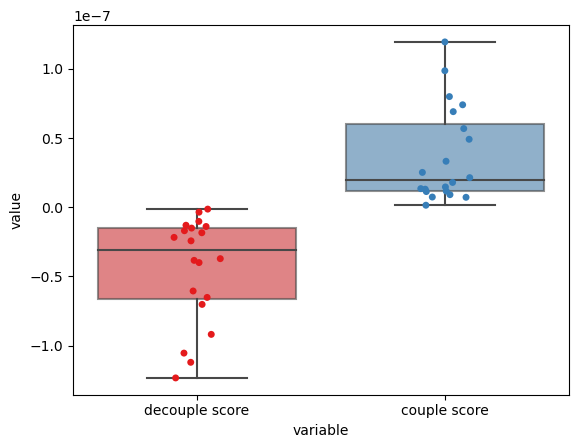

In [37]:
import seaborn as sns
df = pd.DataFrame({"decouple score": scores_decouple, "couple score": scores_couple})
df = df.melt(value_vars=["decouple score", "couple score"])
ax = sns.boxplot(data=df, x="variable", y="value", boxprops={'alpha': 0.6}, palette="Set1")
sns.stripplot(data=df, x="variable", y="value", dodge=True, ax=ax,palette="Set1")
plt.savefig("hair_gene_peak/latent_rep_decouple_score.png", dpi=300)
# ax.set_yticklabels(ax.get_yticks(), size = 14)
# ax.set_xticklabels(ax.get_xticks(), size = 14)